In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sps
import jlinops

In [52]:
m = 200
n = 100
Amat = np.random.normal(size=(m,n))
A = jlinops.MatrixLinearOperator(Amat)
b = np.random.normal(size=(m))
b = np.cumsum(b)

In [53]:
k = 10

# Setup
B = sps.lil_matrix((k+1, k))
W = np.zeros((n,k))
Z = np.zeros((m, k+1))
w = np.zeros(n)
beta = np.linalg.norm(b)
z = b/beta
Z[:,0] = z
B[1,0] = beta

# Perform bidiagonalization
for l in range(k):
    tmp = A.rmatvec(z) - beta*w
    alpha = np.linalg.norm(tmp)
    B[l,l] = alpha
    w = (1.0/alpha)*tmp
    W[:,l] = w
    tmp = A.matvec(w) - alpha*z
    beta = np.linalg.norm(tmp)
    B[l+1,l] = beta
    z = (1.0/beta)*tmp
    Z[:,l+1] = z

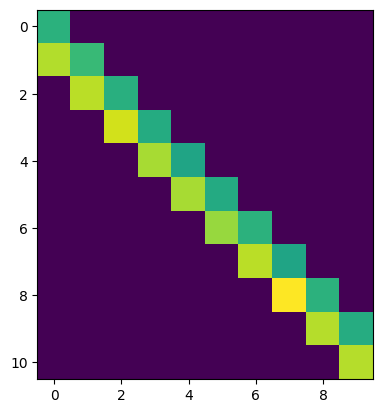

In [54]:
plt.imshow(B.toarray())
plt.show()

In [55]:
print( np.linalg.norm( A.matmat(W) - (Z @ B) ) )

1.9843994189282038e-14


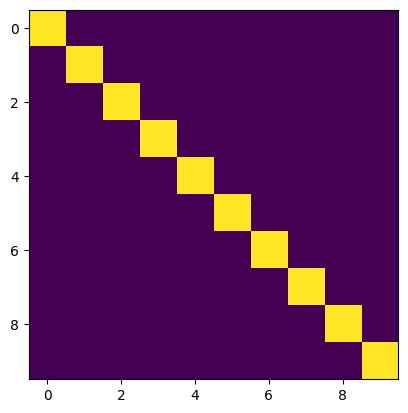

In [56]:
plt.imshow(W.T @ W)
plt.show()

In [57]:
W.shape

(100, 10)

In [58]:
def lanczos_bidiag(A, b, k=6):
    """Given a (m x n) LinearOperator A and a parameter k, 
    produces W, Z, B such that A W = Z B.
    Here the columns of W are an orthonormal basis for K_k(),
    Z is dense, and B is a sparse matrix with only the main diagonal
    and first lower diagonal nonzero.
    """

    # Setup
    m, n = A.shape
    B = sps.lil_matrix((k+1, k))
    W = np.zeros((n,k))
    AW = np.zeros((m,k))
    Z = np.zeros((m, k+1))
    w = np.zeros(n)
    beta = np.linalg.norm(b)
    z = b/beta
    Z[:,0] = z
    B[1,0] = beta

    # Perform bidiagonalization
    for l in range(k):
        tmp = A.rmatvec(z) - beta*w
        alpha = np.linalg.norm(tmp)
        B[l,l] = alpha
        w = (1.0/alpha)*tmp
        W[:,l] = w
        Aw = A.matvec(w)
        AW[:,l] = Aw
        tmp = Aw - alpha*z
        beta = np.linalg.norm(tmp)
        B[l+1,l] = beta
        z = (1.0/beta)*tmp
        Z[:,l+1] = z
        
    W = jlinops.MatrixLinearOperator(W)
    Z = jlinops.MatrixLinearOperator(Z)
    B = jlinops.MatrixLinearOperator(B)
    AW = jlinops.MatrixLinearOperator(AW)
        
    return W, Z, B, AW

In [59]:
W, Z, B, AW = lanczos_bidiag(A, b)

In [66]:
def projected_rlstsq(A, b, k=6, lam=1.0):
    """Solves 
    min_x || A W_k z - b ||_2^2 + lam*|| z ||_2^2
    where W_k is an orthonormal basis for K_k.
    """
    # Perform bidiagonalization
    W, Z, B, AW = lanczos_bidiag(A, b, k=k)
    AW = AW.A
    Atilde = np.vstack([AW, np.sqrt(lam)*np.eye(AW.shape[1])])
    zeros = np.zeros(AW.shape[1])
    btilde = np.hstack([b, zeros])
    sol, _, _, _ = np.linalg.lstsq(Atilde, btilde, rcond=None)
    return W @ sol

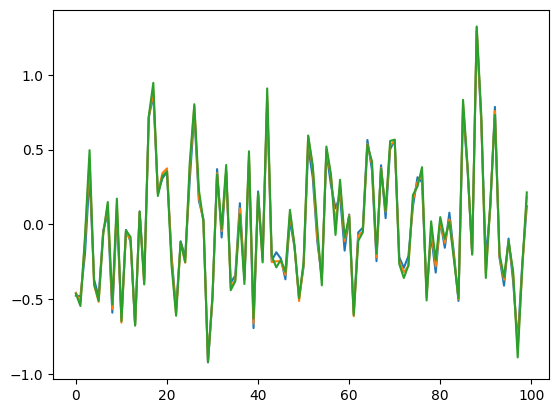

In [73]:
lam = 1e-3
ks = [5, 6, 7]

for k in ks:
    plt.plot(projected_rlstsq(A, b, k=k, lam=lam))
plt.show()